# A `chexoplanet` example

Here is a rough guide to using `chexoplanet` - a way to model planets with both TESS & Cheops data (and even RVs) using the `exoplanet`, `celerite2` and `PyMC3` codes at the back end.

First let's import some stuff:

In [1]:
%load_ext autoreload
%autoreload 2
from chexoplanet import fit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Matplotlib created a temporary config/cache directory at /var/folders/p0/tmr0j01x4jb3qrbc5b0gnxcw0000gn/T/matplotlib-u25pv49s because the default path (/Users/hosborn/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


#### Importing the lightcurve

Here I use my own lightcurve module, but feel free to do this however you like, such as downloading direct from MAST.

All we'll need is `time`, `flux` and `flux_err` arrays (in ppt).

In [2]:
from MonoTools.MonoTools import lightcurve

lc=lightcurve.multilc(100990000,'tess', use_fast=True)
coords=lc.radec

Getting all IDs


## Initialising the Model

Here we need to give the star a name, tell the model the coordinates, and possibly start adding some key decisions on how to model the data.

Scroll all the way down the bottom to see some of the key modelling keywords you could put into the model (though you should be able to add these at any point, either into the function, or with e.g. `mod.fit_phi_gp=True`).

In [3]:
mod = fit.chexo_model("TOI411", radec=coords, overwrite=True)

### Adding the TESS lightcurve to the model:

In [4]:
mod.add_lc(lc.time+2457000,lc.flux,lc.flux_err)

#### Adding the cheops lightcurves:

If you don't have PIPE lightcurves, then honestly, go get some from Alexis because they absolutely rock compared to the DRP ones. 

But the standard DRP fits file should also work in `add_cheops_lc` too:

Unfortunately Cheops GTO data is proprietary, so this data _is not_ available for public use. Sorry!

In [5]:
import glob
for file in glob.glob("/Volumes/LUVOIR/Cheops_data/TOI411/pipefiles/*"):
    mod.add_cheops_lc(filekey=file.split('_')[-2],fileloc=file,PIPE=True,DRP=False)

#### Adding the stellar info:

In [6]:
mod.init_starpars(Rstar=[1.117,0.009,0.009],Teff=[6169,64,64],
                  logg=[4.47,0.11,0.11],Mstar=[1.098,0.040,0.040],FeH=-0.08)

### Initialising the planets to fit:

We need to give the model reasonable guesses at planet parameters. Not all these parameters are key, but you need to include:
* `tcen`
* `period` (in days)
* `tdur` transit duration (in days)
* `depth` (as a ratio)

And ideally a `tcen_err` and/or a `period_err` too. `b` isn't usually necessary.

In [7]:
mod.add_planet(name='b',tcen=2457000+1385.733,period=4.04028301,tdur=0.145833,depth=0.000143,tcen_err=0.002,
                   period_err=0.0002,b=0.327)
mod.add_planet(name='c',tcen=2457000+2161.609,period=9.57308388,tdur=0.158333,depth=0.00037,tcen_err=0.001,
                   period_err=0.0002,b=0.38)
mod.add_planet(name='d',tcen=2457000+2136.536,period=47.42486448,tdur=0.145833,depth=0.00045,tcen_err=0.001,
                   period_err=0.001,b=0.32)

# Initialising the LC

Here let's take the simplest (i.e. quickest) approach, and only fit to the data near transit with a pre-flattened lightcurve. i.e. we need to set `fit_gp=False` & `fit_flat=True` to pre-flatten and `cut_oot=True`, `bin_oot=False` to make sure out-of-transit data is not just binned but cut entirely. This should speed things along.

In [8]:
mod.init_lc(fit_gp=False, fit_flat=True, cut_oot=True, bin_oot=False)

485


### Initialising the Cheops LC

Which parameters should we detrend with? 

Here, `chexoplanet` copies `pycheops` to run an initial model with all detrending params and assessing which produce useful information using the bayes factor (if you set `use_bayes_fact=True`). Or you can simply take all parameters which are significant (`use_signif=False`).

_note: this can be slow for many filekeys as we need to model each one_

In [9]:
mod.init_cheops(use_bayes_fact=True,use_signif=False)

485
Performing Cheops-only minimisation with all detrending params for filekey  10001


optimizing logp for variables: [logs_cheops, logror_b, per_b, t0_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -2631.453029357427 -> 95.94352885582626
optimizing logp for variables: [d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, logs_cheops, cheops_mean, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi]


message: Optimization terminated successfully.
logp: 95.94352885582626 -> 805.7306158726988
optimizing logp for variables: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: 805.7306158726988 -> 825.0502900245272
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 112 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Performing Cheops-only minimisation with all detrending params for filekey  10101


optimizing logp for variables: [logs_cheops, logror_d, logror_c, per_d, per_c, t0_d, t0_c, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -1497.531043131149 -> 312.8198935063936
optimizing logp for variables: [d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, logs_cheops, cheops_mean, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi]


message: Desired error not necessarily achieved due to precision loss.
logp: 312.8198935063936 -> 737.0943185939431
optimizing logp for variables: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_d, t0_d, b_d, logror_d, per_c, t0_c, b_c, logror_c, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: 737.0943185939431 -> 825.8716880700224
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_d, t0_d, b_d, logror_d, per_c, t0_c, b_c, logror_c, u_star_cheops, Ms, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 67 seconds.


Performing Cheops-only minimisation with all detrending params for filekey  21101


optimizing logp for variables: [logs_cheops, logror_c, per_c, t0_c, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -6287.787358185804 -> -154.81330713246487
optimizing logp for variables: [d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, logs_cheops, cheops_mean, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi]


message: Optimization terminated successfully.
logp: -154.81330713246487 -> 696.9767120652142
optimizing logp for variables: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_c, t0_c, b_c, logror_c, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: 696.9767120652142 -> 705.3340851358153
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_c, t0_c, b_c, logror_c, u_star_cheops, Ms, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 57 seconds.


Performing Cheops-only minimisation with all detrending params for filekey  21201


optimizing logp for variables: [logs_cheops, logror_b, per_b, t0_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -663.1735149106574 -> 286.6755536429342
optimizing logp for variables: [d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, logs_cheops, cheops_mean, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi]


message: Optimization terminated successfully.
logp: 286.6755536429342 -> 732.4521549344062
optimizing logp for variables: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: 732.4521549344062 -> 732.5871497816463
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 461 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Performing Cheops-only minimisation with all detrending params for filekey  21202


optimizing logp for variables: [logs_cheops, logror_b, per_b, t0_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: -680.816609154977 -> 243.76946316015815
optimizing logp for variables: [d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, logs_cheops, cheops_mean, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi]


message: Desired error not necessarily achieved due to precision loss.
logp: 243.76946316015815 -> 604.4022132028794
optimizing logp for variables: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


message: Desired error not necessarily achieved due to precision loss.
logp: 604.4022132028794 -> 607.8804272827241
Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [cheops_mean, d2fddeltaT2, d2fdtime2, d2fdcosphi2, d2fdsinphi2, d2fdcentroid_y2, d2fdcentroid_x2, d2fdbg2, dfddeltaT, dfdtime, dfdcentroid_y, dfdcentroid_x, dfdbg, dfdcosphi, dfdsinphi, logs_cheops, per_b, t0_b, b_b, logror_b, u_star_cheops, Ms, Rs]


Sampling 3 chains for 300 tune and 400 draw iterations (900 + 1_200 draws total) took 112 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Here are the direct assessments (in either sigma or Bayes Factors) for each detrending parameter:

In [10]:
mod.linear_assess,mod.quad_assess

({'10001': {'sinphi': 7.0307501243704955,
   'cosphi': 7.153308140302872,
   'bg': 34.643240126065486,
   'centroid_x': 123.67978087954089,
   'centroid_y': 0.0005908553614549362,
   'time': 8.451712341292449,
   'deltaT': 19.160309316985757},
  '10101': {'sinphi': 5.888604248283909,
   'cosphi': 5.912164054109801,
   'bg': 23.335340049264264,
   'centroid_x': 11.282570489861568,
   'centroid_y': 3.333942394072312e-05,
   'time': 2.726279642831991e-07,
   'deltaT': 48.01686581289876},
  '21101': {'sinphi': 6.013378345938637,
   'cosphi': 5.990226601809456,
   'bg': 14.148499109800339,
   'centroid_x': 0.018283764593807185,
   'centroid_y': 2.7390406186662855,
   'time': 3.7998475908374956,
   'deltaT': 22.496953597062337},
  '21201': {'sinphi': 38.87815771437744,
   'cosphi': 9.757847309197617,
   'bg': 0.2416426116581022,
   'centroid_x': 5.1056563557823e-10,
   'centroid_y': 0.0068158105730668755,
   'time': 7.477453851223778e-07,
   'deltaT': 34.87174991253135},
  '21202': {'sinphi'

### Adding RVs

Do this seperately for each instrument in your collection.

If you set `npoly_rv=1` then only the offsets between each instrument are modelled, otherwise `npoly_rv=2` gives a linear background model, and `npoly_rv>2` gives more complex polynomial models.

In [11]:
import pandas as pd
rvtab=pd.read_csv("toi411_rvs.txt")

mod.add_rvs(rvtab['t'].values, rvtab['vel'].values, rvtab['errvel'].values, name='Espresso', overwrite=True,
            npoly_rv=1)

# Initialising the model

Now all that is done, we use `init_model` to initialise the `PyMC3` model.

Here we could tell the model which stellar parameters to use (i.e. either logg using `fit_logg` or Ms `fit_mstar` - use whichever is more precise), whether to constrain the Limb Darkening parameters around the theoretical values, whether to fit individial transit times (`fit_ttvs`) and whether to fit a circular or eccentric orbit (`assume_circ`)

In [12]:
mod.init_model(use_mstar=True,constrain_lds=True,fit_ttvs=True,assume_circ=True)

10001 {'centroid_y': (689,)}


optimizing logp for variables: [dfdcentroid_y_21201, dfdbg_21201, dfdcentroid_x_21201, dfdtime_21201, dfdcentroid_x_21101, dfdcentroid_y_10101, dfdtime_10101, dfdcentroid_y_10001, logs_cheops, logs_tess, logror, transit_times_d, transit_times_c, transit_times_b]


message: Desired error not necessarily achieved due to precision loss.
logp: -17453.26413266291 -> -10331.055606971682
optimizing logp for variables: [d2fdcentroid_y2_21202, d2fdbg2_21201, d2fdcentroid_x2_21101, d2fdcentroid_y2_10101, logs_cheops, cheops_mean_21202, cheops_mean_21201, cheops_mean_21101, cheops_mean_10101, cheops_mean_10001, dfdcentroid_y_21201, dfdbg_21201, dfdcentroid_x_21201, dfdtime_21201, dfdcentroid_x_21101, dfdcentroid_y_10101, dfdtime_10101, dfdcentroid_y_10001]


message: Optimization terminated successfully.
logp: -10331.055606971682 -> -10321.622654956733
optimizing logp for variables: [rv_offsets, logK, u_starcheops, u_startess, transit_times_d, transit_times_c, transit_times_b, logs_cheops, logs_tess, logror, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -17453.26413266291 -> 6653.169643491124
optimizing logp for variables: [rv_logjitter, rollangle_lengthscale, rollangle_power, cheops_mean_21202, cheops_mean_21201, cheops_mean_21101, cheops_mean_10101, cheops_mean_10001, d2fdcentroid_y2_21202, d2fdbg2_21201, dfdcentroid_y_21201, dfdbg_21201, dfdcentroid_x_21201, dfdtime_21201, d2fdcentroid_x2_21101, dfdcentroid_x_21101, d2fdcentroid_y2_10101, dfdcentroid_y_10101, dfdtime_10101, dfdcentroid_y_10001, logs_cheops, logs_tess, rv_offsets, u_starcheops, u_startess, b, logror, logK, transit_times_d, transit_times_c, transit_times_b, Ms, Rs, Teff]


message: Desired error not necessarily achieved due to precision loss.
logp: 6653.169643491124 -> 13958.40972926374


### Inspecting the model by plotting:

There are a few functions which should enable us to inspect whether the above initial model fit was OK.

At this stage, running these functions uses only the initial solution (`init_soln`), but once the model is sampled, it will use the output `trace` instead.

##### Roll angle GP:
`plot_rollangle_gps` plots the Cheops GP as a function of rollangle:

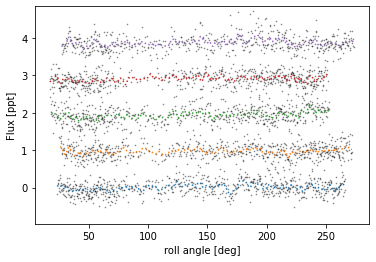

In [13]:
mod.plot_rollangle_gps(save=False)

##### Cheops photometry:
`plot_cheops` plots the Cheops raw & detrended lightcurves for each filekey:

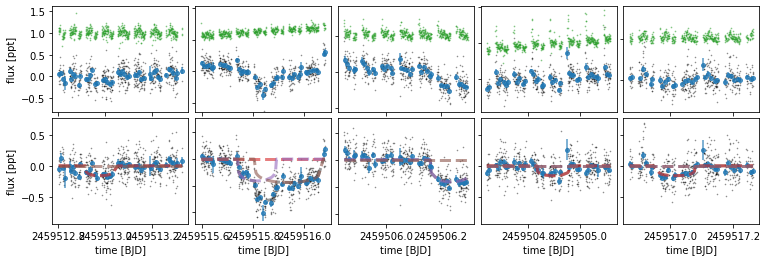

In [14]:
mod.plot_cheops(save=False)

##### RVs:
`plot_rvs` plots the RVs and their best-fit models

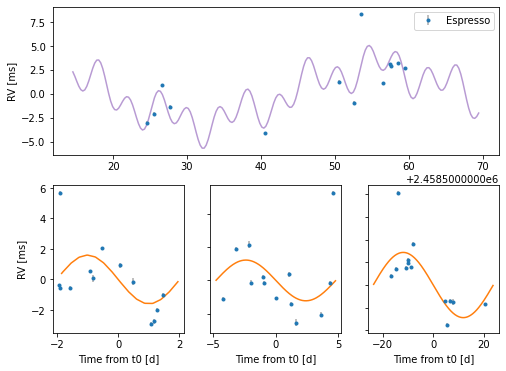

In [15]:
mod.plot_rvs(save=False)

##### TESS photometry:
`plot_tess` plots the TESS photometry and either the best-fit GP and transit fit, or the best-fit transit fit added to the spline used to pre-detrend the TESS data

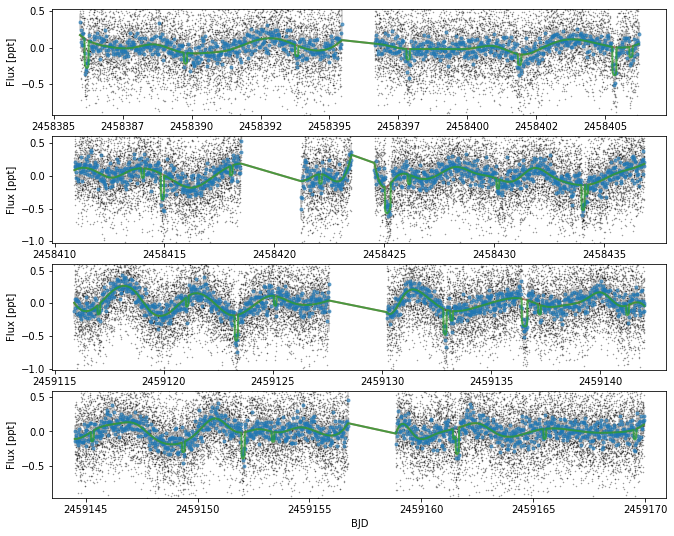

In [16]:
mod.plot_tess(save=False)

## How does that look?

If it looks weird, then no sweat. If it looks like the planetary model is doing something weird (maybe you're missing a transit), then try to modify the data you supplied to `mod.planets`... i.e. make sure the ephemeris you have matches all the transits in the data. You will need to re-run `init_model()` and maybe `init_lc()` if you change the input planet data.

If your Cheops model seems to be all over the place, you could try to switch from `use_bayes_fact` to `use_signif` (and maybe increase the `signif_thresh`) - that might limit the number of detrending params and make sampling easier for the model. You could also turn off the GP using `fit_phi_gp=False`. After doing any of that, you'll need to run `init_cheops()` again (sorry)

If TESS is doing something funky like absorbing the transits then you can try to swap between pre-flattening (`fit_flat`) and using a GP (`fit_gp`). Or, you could change the `flat_knotdist` for the spline-based fitting which might make the spline better able to absorb sharp systematic features. (You should run `init_lc()` if you modify these parameters. Alternatively, you could try to use a lightcurve from a different detrending source (i.e. use the QLP or HLSP-SPOC lightcurve, or find someone to do their own PSF detrending like Tom Wilson or Andrew Vanderburg).

If the RVs are doing something weird, then there's not much to do beyond changing `npoly_rv`. You could try to mask points before feeing the RVs to `add_rvs()`? 

## Sampling the model

If all the initial plots seem OK, and you've got a good fit with this model, then we can sample the model using `sample_model`.
These parameters are super short to get through this notebook. If you want production-level samples then you probably want to tune and draw a few thousand samples from a dozen cores/chains (here `n_chains` is _per core_ so we effectively have 3 walkers)

In [17]:
mod.sample_model(n_tune_steps=600,n_draws=400,n_cores=3,n_chains=1)

Only 400 samples in chain.
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [rv_logjitter, rollangle_lengthscale, rollangle_power, cheops_mean_21202, cheops_mean_21201, cheops_mean_21101, cheops_mean_10101, cheops_mean_10001, d2fdcentroid_y2_21202, d2fdbg2_21201, dfdcentroid_y_21201, dfdbg_21201, dfdcentroid_x_21201, dfdtime_21201, d2fdcentroid_x2_21101, dfdcentroid_x_21101, d2fdcentroid_y2_10101, dfdcentroid_y_10101, dfdtime_10101, dfdcentroid_y_10001, logs_cheops, logs_tess, rv_offsets, u_starcheops, u_startess, b, logror, logK, transit_times_d, transit_times_c, transit_times_b, Ms, Rs, Teff]


Sampling 3 chains for 600 tune and 400 draw iterations (1_800 + 1_200 draws total) took 1489 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### Plotting the result

We can re-run the same plotting functions as before. Leaving out `save=False` will mean these are written to file.

To specify the file location, modify the `save_file_loc` parameter.

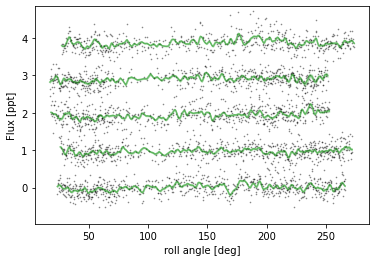

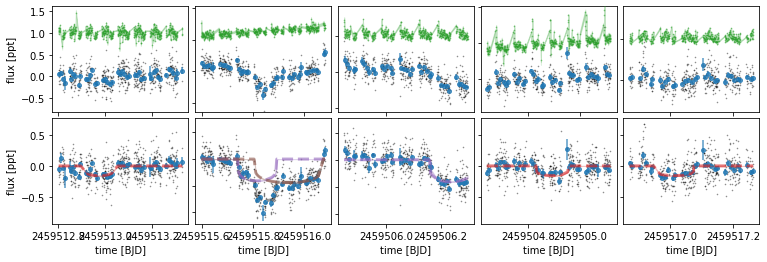

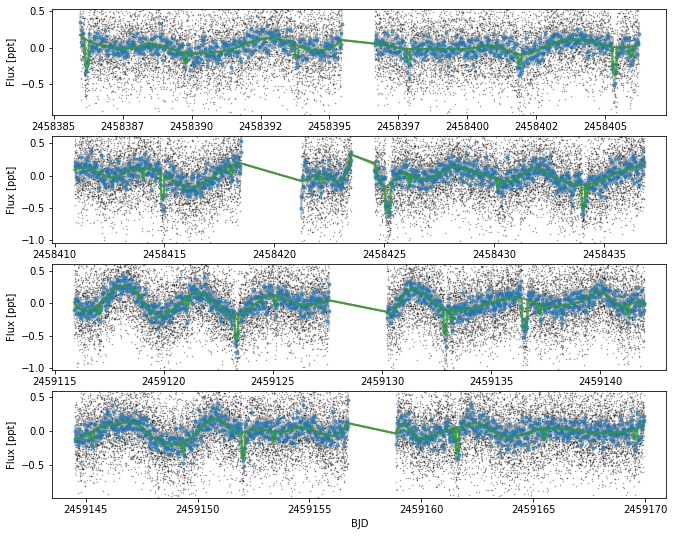

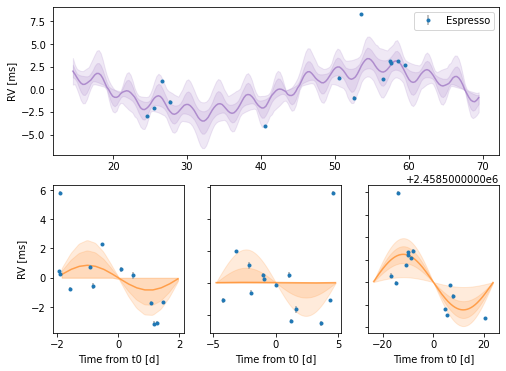

In [21]:
mod.plot_rollangle_gps()
mod.plot_cheops()
mod.plot_tess()
mod.plot_rvs()

# Saving the results

This model produces two key types of output:
* Sampled parameters and uncertainties
* Modelled timeseries for plotting

###### Parameters

To save a summary of the parameters, we can use `save_trace_summary` which automatically outputs a csv file.
This should automatically remove the `__interval_` transformed parameters as well as the high-dimensional model predictions for e.g. RVs & lightcurves.

In [22]:
df=mod.save_trace_summary()
df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,5%,-$1\sigma$,median,+$1\sigma$,95%
transit_times_b[0],2.458390e+06,0.007189,2.458390e+06,2.458390e+06,0.004109,0.003238,3.795994,58.644019,2.390370,2.458390e+06,2.458390e+06,2.458390e+06,2.458390e+06,2.458390e+06
transit_times_b[1],2.458394e+06,0.001755,2.458394e+06,2.458394e+06,0.001003,0.000791,4.971090,20.024510,1.697998,2.458394e+06,2.458394e+06,2.458394e+06,2.458394e+06,2.458394e+06
transit_times_b[2],2.458398e+06,0.000495,2.458398e+06,2.458398e+06,0.000283,0.000223,4.367646,68.962653,1.878143,2.458398e+06,2.458398e+06,2.458398e+06,2.458398e+06,2.458398e+06
transit_times_b[3],2.458402e+06,0.000240,2.458402e+06,2.458402e+06,0.000025,0.000108,3.782706,56.301458,2.370071,2.458402e+06,2.458402e+06,2.458402e+06,2.458402e+06,2.458402e+06
transit_times_b[4],2.458406e+06,0.000537,2.458406e+06,2.458406e+06,0.000307,0.000242,4.600101,17.824088,1.760445,2.458406e+06,2.458406e+06,2.458406e+06,2.458406e+06,2.458406e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tdur[2],1.134146e-01,0.000156,1.131487e-01,1.136029e-01,0.000084,0.000065,4.144527,50.796378,2.060183,1.131531e-01,1.132096e-01,1.134682e-01,1.135621e-01,1.135841e-01
rollangle_power,1.094556e-02,0.000416,1.029470e-02,1.134286e-02,0.000235,0.000184,4.875400,33.797399,1.686095,1.030128e-02,1.035272e-02,1.118160e-02,1.129595e-02,1.133466e-02
rollangle_lengthscale,7.102701e+00,0.114363,6.897685e+00,7.274242e+00,0.062411,0.048665,3.770585,34.166780,2.416889,6.909459e+00,6.953498e+00,7.120310e+00,7.226918e+00,7.270952e+00
rollangle_w0,8.848493e-01,0.014312,8.637581e-01,9.109122e-01,0.007808,0.006087,3.770585,34.166780,2.416889,8.641490e-01,8.694142e-01,8.824314e-01,9.036006e-01,9.093600e-01


###### Timeseries

To save the timeseries, we can use `save_timeseries`. 
In this case, it will create csvs for each modelled timeseries, i.e.:
* TESS photometry
* Cheops photometry (stacked but with a "filekey" column unique for each visit
* RV observations and modelled variations for each radial velocity point
* RV models for a fine grid of time during the observations

In [23]:
models_out=mod.save_timeseries(returnobj=True)
models_out

{'tess':                time      flux  flux_err  mask  in_trans  near_trans    spline  \
 2691   2.458386e+06 -0.147739  0.315059  True     False        True  0.172417   
 2692   2.458386e+06  0.831398  0.315207  True     False        True  0.171973   
 2693   2.458386e+06  0.575974  0.315128  True     False        True  0.171531   
 2694   2.458386e+06 -0.106891  0.315035  True     False        True  0.171089   
 2695   2.458386e+06  0.191156  0.315089  True     False        True  0.170648   
 ...             ...       ...       ...   ...       ...         ...       ...   
 71606  2.459170e+06  0.208118  0.308717  True     False        True  0.100810   
 71607  2.459170e+06  0.158774  0.308676  True     False        True  0.101140   
 71608  2.459170e+06  0.225537  0.308607  True     False        True  0.101471   
 71609  2.459170e+06  0.362522  0.308658  True     False        True  0.101802   
 71610  2.459170e+06  0.098688  0.308732  True     False        True  0.102135   
 
      

## Behind the scenes

Here's all the objects associated with the model:

##### The planets
* `mod.planets` is a dictionary of planetary info (also dicts)

###### Names
* `mod.name` - the target name specified when intialising the class
* `mod.save_file_loc` - the directory in which to store the outputs
* `mod.unq_name` - the unique name for this combination of date, target and model settings

###### Cheops timeseries and metadata
* `mod.cheops_lc` stores the Cheops observations as a pandas DataFrame
* `mod.cheops_filekeys` a list of all Cheops filekeys
* `mod.cheops_fk_mask` is a dictionary of masks for each unique filekey which can be used to index `mod.cheops_lc`
* `mod.norm_cheops_dat` pandas DataFrame of detrending parameters normalised to have $\mu=0.0$ and $\sigma=1.0$.
* `mod.init_chefit_summaries` the results from each initial Cheops filekey fit, later used to initialise the combined model.
* `mod.cheops_mads` the median absolute differences for the Cheops data
* `mod.linear_assess` a dictionary for each filekey showing the assessments for each linear detrending parameter
* `mod.cheops_linear_decorrs` - a dictionary of linear detrending parameters to be used for each filekey
* `mod.quad_assess` a dictionary for each filekey showing the assessments for each quadratic detrending param
* `mod.cheops_quad_decorrs` - a dictionary of quadratic detrending parameters to be used for each filekey

###### Other timeseries and metadata
* `mod.lcs` stores lightcurves for each photometric source that is not Cheops (currently only tested for TESS,  i.e. `mod.lcs['tess']` as a pandas DataFrame
* `mod.binlc` - as `mod.lcs` but binned rather than raw.
* `mod.lc_fit` is the above lightcurves which have been specfically masked/binned/etc for modelling, again as a pandas DataFrame
* `mod.rvs` is a pandas DataFrame of the RV measurements with key columns of `time`, `y`, `yerr`, and `scope`

###### Derived stellar data
* `mod.Rstar`,`mod.Mstar`,`mod.logg`,`mod.Teff` store lists of the value, +ve and -ve uncertainties for each stellar parameter
* `mod.ld_dists` holds the randomly drawn quadratic limb darkening parameters for each instrument.

###### Objects used and/or produced during modelling
* `mod.model_params` the `PyMC3` model parameters initialised in the model
* `mod.init_soln` - the initial best-fit solution found by `init_model`
* `mod.trace` - the final matrix of solutions explored by `sample_model`

###### Settings
* `debug` print debug statements?
* `fit_gp` - co-fit a GP.
* `fit_flat` - flatten the lightcurve before modelling
* `flat_knotdist` - Length of knotdistance for flattening spline (in days)
* `train_gp` - Train the GP hyperparameters on out-of-transit data
* `cut_distance` - cut out points further than cut_distance*Tdur. 0.0 means no cutting
* `mask_distance` - Distance, in transit durations, from set transits, to "mask" as in-transit data when e.g. flattening.
* `cut_oot` - Cut points outside the cut_distance when fitting
* `bin_size` - Size of binned points (defaults to 30mins)
* `bin_oot` - Bin points outside the cut_distance to 30mins
* `use_bayes_fact` - Determine the detrending factors to use with a Bayes Factor
* `use_signif` - Determine the detrending factors to use by simply selecting those with significant non-zero coefficients
* `signif_thresh` - Threshold for detrending parameters in sigma
* `assume_circ` - Assume circular orbits (no ecc & omega)?
* `fit_ttvs` - Fit a TTVorbit exoplanet model which searches for TTVs
* `fit_phi_gp` - co-fit a GP to the roll angle.
* `npoly_rv` - order of polynomial fit to RVs
* `use_mstar` - Whether to model using the stellar Mass (otherwise set use_logg)
* `use_logg` - Whether to model using the stellar logg (otherwise Mass)
* `constrain_lds` - Use constrained LDs from model or unconstrained?
* `ld_mult` - How much to multiply theoretical LD param uncertainties
* `fit_contam` - fit contamination in the TESS and Cheops LCs?